inputs = (n_inputs, pixel_width, pixel_height) = (1797, 8, 8)
labels = (n_inputs) = (1797,)
X = (n_inputs, n_features) = (1797, 64)


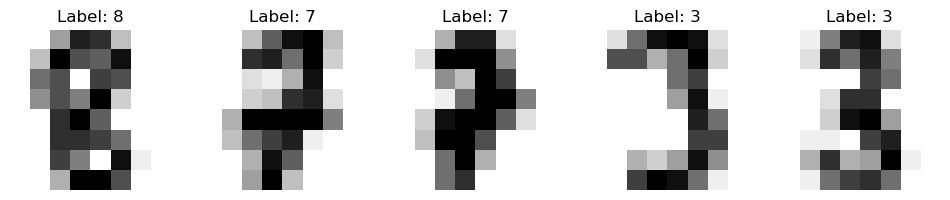

In [1]:
%matplotlib inline

# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets


# ensure the same random numbers appear every time
np.random.seed(0)

# display images in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,12)


# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

print("inputs = (n_inputs, pixel_width, pixel_height) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))


# flatten the image
# the value -1 means dimension is inferred from the remaining dimensions: 8x8 = 64
n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)
print("X = (n_inputs, n_features) = " + str(inputs.shape))


# choose some random images to display
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[random_indices[i]])
plt.show()

In [2]:
from sklearn.model_selection import train_test_split

# one-liner from scikit-learn library
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)

# equivalently in numpy
def train_test_split_numpy(inputs, labels, train_size, test_size):
    n_inputs = len(inputs)
    inputs_shuffled = inputs.copy()
    labels_shuffled = labels.copy()
    
    np.random.shuffle(inputs_shuffled)
    np.random.shuffle(labels_shuffled)
    
    train_end = int(n_inputs*train_size)
    X_train, X_test = inputs_shuffled[:train_end], inputs_shuffled[train_end:]
    Y_train, Y_test = labels_shuffled[:train_end], labels_shuffled[train_end:]
    
    return X_train, X_test, Y_train, Y_test

#X_train, X_test, Y_train, Y_test = train_test_split_numpy(inputs, labels, train_size, test_size)

print("Number of training images: " + str(len(X_train)))
print("Number of test images: " + str(len(X_test)))

Number of training images: 1437
Number of test images: 360


In [3]:
# building our neural network

n_inputs, n_features = X_train.shape
n_hidden_neurons = 50
n_categories = 10

# we make the weights normally distributed using numpy.random.randn

# weights and bias in the hidden layer
hidden_weights = np.random.randn(n_features, n_hidden_neurons)
hidden_bias = np.zeros(n_hidden_neurons) + 0.01

# weights and bias in the output layer
output_weights = np.random.randn(n_hidden_neurons, n_categories)
output_bias = np.zeros(n_categories) + 0.01

In [4]:

# setup the feed-forward pass, subscript h = hidden layer

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def feed_forward(X):
    # weighted sum of inputs to the hidden layer
    z_h = np.matmul(X, hidden_weights) + hidden_bias
    # activation in the hidden layer
    a_h = sigmoid(z_h)
    
    # weighted sum of inputs to the output layer
    z_o = np.matmul(a_h, output_weights) + output_bias
    # softmax output
    # axis 0 holds each input and axis 1 the probabilities of each category
    exp_term = np.exp(z_o)
    probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
    
    return probabilities

probabilities = feed_forward(X_train)
print("probabilities = (n_inputs, n_categories) = " + str(probabilities.shape))
print("probability that image 0 is in category 0,1,2,...,9 = \n" + str(probabilities[0]))
print("probabilities sum up to: " + str(probabilities[0].sum()))
print()

# we obtain a prediction by taking the class with the highest likelihood
def predict(X):
    probabilities = feed_forward(X)
    return np.argmax(probabilities, axis=1)

predictions = predict(X_train)
print("predictions = (n_inputs) = " + str(predictions.shape))
print("prediction for image 0: " + str(predictions[0]))
print("correct label for image 0: " + str(Y_train[0]))

probabilities = (n_inputs, n_categories) = (1437, 10)
probability that image 0 is in category 0,1,2,...,9 = 
[5.41511965e-04 2.17174962e-03 8.84355903e-03 1.44970586e-03
 1.10378326e-04 5.08318298e-09 2.03256632e-04 1.92507116e-03
 9.84443254e-01 3.11507992e-04]
probabilities sum up to: 1.0

predictions = (n_inputs) = (1437,)
prediction for image 0: 8
correct label for image 0: 6


In [5]:
# to categorical turns our integer vector into a onehot representation
from sklearn.metrics import accuracy_score

# one-hot in numpy
def to_categorical_numpy(integer_vector):
    n_inputs = len(integer_vector)
    n_categories = np.max(integer_vector) + 1
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs), integer_vector] = 1
    
    return onehot_vector

#Y_train_onehot, Y_test_onehot = to_categorical(Y_train), to_categorical(Y_test)
Y_train_onehot, Y_test_onehot = to_categorical_numpy(Y_train), to_categorical_numpy(Y_test)

def feed_forward_train(X):
    # weighted sum of inputs to the hidden layer
    z_h = np.matmul(X, hidden_weights) + hidden_bias
    # activation in the hidden layer
    a_h = sigmoid(z_h)
    
    # weighted sum of inputs to the output layer
    z_o = np.matmul(a_h, output_weights) + output_bias
    # softmax output
    # axis 0 holds each input and axis 1 the probabilities of each category
    exp_term = np.exp(z_o)
    probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
    
    # for backpropagation need activations in hidden and output layers
    return a_h, probabilities

def backpropagation(X, Y):
    a_h, probabilities = feed_forward_train(X)
    
    # error in the output layer
    error_output = probabilities - Y
    # error in the hidden layer
    error_hidden = np.matmul(error_output, output_weights.T) * a_h * (1 - a_h)
    
    # gradients for the output layer
    output_weights_gradient = np.matmul(a_h.T, error_output)
    output_bias_gradient = np.sum(error_output, axis=0)
    
    # gradient for the hidden layer
    hidden_weights_gradient = np.matmul(X.T, error_hidden)
    hidden_bias_gradient = np.sum(error_hidden, axis=0)

    return output_weights_gradient, output_bias_gradient, hidden_weights_gradient, hidden_bias_gradient

print("Old accuracy on training data: " + str(accuracy_score(predict(X_train), Y_train)))

eta = 0.01
lmbd = 0.01
for i in range(1000):
    # calculate gradients
    dWo, dBo, dWh, dBh = backpropagation(X_train, Y_train_onehot)
    
    # regularization term gradients
    dWo += lmbd * output_weights
    dWh += lmbd * hidden_weights
    
    # update weights and biases
    output_weights -= eta * dWo
    output_bias -= eta * dBo
    hidden_weights -= eta * dWh
    hidden_bias -= eta * dBh

print("New accuracy on training data: " + str(accuracy_score(predict(X_train), Y_train)))

Old accuracy on training data: 0.1440501043841336


C:\Users\magnu\AppData\Local\Temp\ipykernel_20460\3248255476.py:4: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


New accuracy on training data: 0.09394572025052192


In [7]:
predictions = predict(X_train)
print("predictions = (n_inputs) = " + str(predictions.shape))
for i in range(10):
    print(f"prediction for image {i}: " + str(predictions[i]))
    print(f"correct label for image {i}: " + str(Y_train[i]))

predictions = (n_inputs) = (1437,)
prediction for image 0: 2
correct label for image 0: 6
prediction for image 1: 2
correct label for image 1: 3
prediction for image 2: 2
correct label for image 2: 8
prediction for image 3: 2
correct label for image 3: 1
prediction for image 4: 2
correct label for image 4: 7
prediction for image 5: 2
correct label for image 5: 4
prediction for image 6: 2
correct label for image 6: 3
prediction for image 7: 2
correct label for image 7: 4
prediction for image 8: 2
correct label for image 8: 6
prediction for image 9: 2
correct label for image 9: 4


C:\Users\magnu\AppData\Local\Temp\ipykernel_20460\3248255476.py:4: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


In [31]:
class NeuralNetwork:
    def __init__(
            self,
            X_data,
            Y_data,
            n_hidden_neurons=50,
            n_categories=10,
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0):

        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_hidden_neurons = n_hidden_neurons
        self.n_categories = n_categories

        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd

        self.create_biases_and_weights()

    def create_biases_and_weights(self):
        self.hidden_weights = np.random.randn(self.n_features, self.n_hidden_neurons)
        self.hidden_bias = np.zeros(self.n_hidden_neurons) + 0.01

        self.output_weights = np.random.randn(self.n_hidden_neurons, self.n_categories)
        self.output_bias = np.zeros(self.n_categories) + 0.01

    def feed_forward(self):
        # feed-forward for training
        self.z_h = np.matmul(self.X_data, self.hidden_weights) + self.hidden_bias
        self.a_h = sigmoid(self.z_h)

        self.z_o = np.matmul(self.a_h, self.output_weights) + self.output_bias

        exp_term = np.exp(self.z_o)
        self.probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)

    def feed_forward_out(self, X):
        # feed-forward for output
        # (50,) (64, 50) (360, 64)
        # (360, 50) (360, 50)
        #print(np.shape(self.hidden_bias), np.shape(self.hidden_weights), np.shape(X))
        z_h = np.matmul(X, self.hidden_weights) + self.hidden_bias
        #print(np.shape(z_h), np.shape(np.matmul(X, self.hidden_weights)))
        a_h = sigmoid(z_h)

        z_o = np.matmul(a_h, self.output_weights) + self.output_bias
        
        exp_term = np.exp(z_o)
        probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        return probabilities

    def backpropagation(self):
        #(100, 10) (100, 10)
        print(np.shape(self.probabilities), np.shape(self.Y_data))
        error_output = self.probabilities - self.Y_data
        error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h * (1 - self.a_h)

        self.output_weights_gradient = np.matmul(self.a_h.T, error_output)
        self.output_bias_gradient = np.sum(error_output, axis=0)

        self.hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
        self.hidden_bias_gradient = np.sum(error_hidden, axis=0)

        if self.lmbd > 0.0:
            self.output_weights_gradient += self.lmbd * self.output_weights
            self.hidden_weights_gradient += self.lmbd * self.hidden_weights

        self.output_weights -= self.eta * self.output_weights_gradient
        self.output_bias -= self.eta * self.output_bias_gradient
        self.hidden_weights -= self.eta * self.hidden_weights_gradient
        self.hidden_bias -= self.eta * self.hidden_bias_gradient

    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        return np.argmax(probabilities, axis=1)

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )
                #(100,)
                #print(np.shape(chosen_datapoints))

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]

                self.feed_forward()
                self.backpropagation()

In [32]:
epochs = 100
batch_size = 100

dnn = NeuralNetwork(X_train, Y_train_onehot, eta=eta, lmbd=lmbd, epochs=epochs, batch_size=batch_size,
                    n_hidden_neurons=n_hidden_neurons, n_categories=n_categories)
dnn.train()
test_predict = dnn.predict(X_test)

# accuracy score from scikit library
print("Accuracy score on test set: ", accuracy_score(Y_test, test_predict))

# equivalent in numpy
def accuracy_score_numpy(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

#print("Accuracy score on test set: ", accuracy_score_numpy(Y_test, test_predict))

TypeError: __init__() got an unexpected keyword argument 'n_hidden_neurons'

In [30]:
for i in range(10):
    print(f"prediction for image {i}: " + str(Y_test[i]))
    print(f"correct label for image {i}: " + str(test_predict[i]))

prediction for image 0: 0
correct label for image 0: 0
prediction for image 1: 3
correct label for image 1: 3
prediction for image 2: 6
correct label for image 2: 6
prediction for image 3: 0
correct label for image 3: 0
prediction for image 4: 2
correct label for image 4: 2
prediction for image 5: 7
correct label for image 5: 7
prediction for image 6: 3
correct label for image 6: 3
prediction for image 7: 7
correct label for image 7: 7
prediction for image 8: 7
correct label for image 8: 7
prediction for image 9: 6
correct label for image 9: 6
